In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from sklearn import decomposition
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks


In [2]:
im = Image.open('SCANS/F20_10_b/6um_jamtveit_att_pag-1.99_3-10000.tif')
imarr = np.array(im)

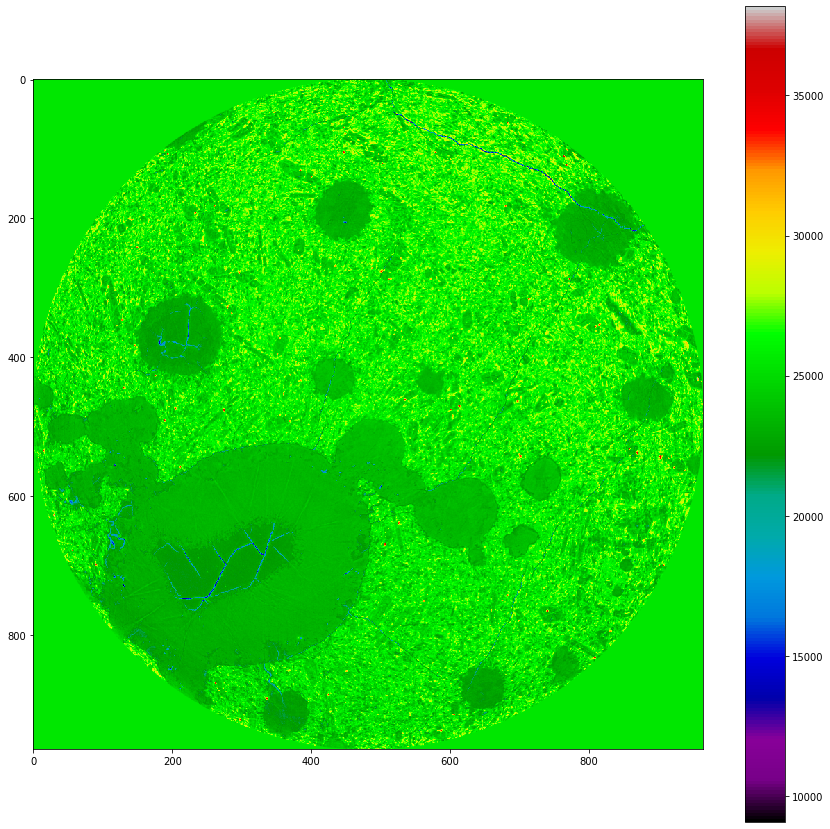

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr, cmap='nipy_spectral')
fig.colorbar(cbar)

In [13]:
"""
creates a mask based on the radius of the sample to remove
outlying data in the scan which is meaningless and not part
of the sample
"""

x = np.arange(imarr.shape[0])
y = np.arange(imarr.shape[1])

cx = imarr.shape[0] // 2
cy = imarr.shape[1] // 2
r = imarr.shape[0] // 2

mask = (x[np.newaxis,:] - cx)**2 + (y[:, np.newaxis] - cy)**2 > r**2

imarr_maskradius = imarr.astype(np.float64)
imarr_maskradius[mask] = np.nan 

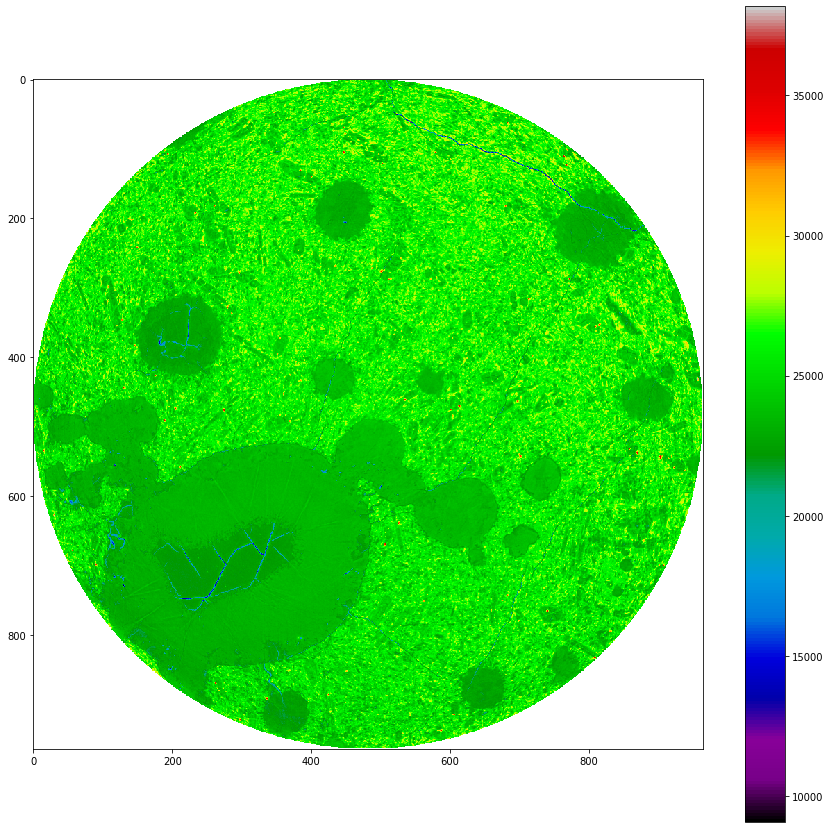

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr_maskradius, cmap='nipy_spectral')
fig.colorbar(cbar)

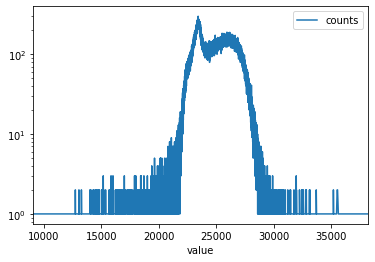

In [15]:
value, counts = np.unique(imarr_maskradius, return_counts=True)
histdf = pd.DataFrame({'value':value, 'counts':counts}).sort_values(by='value')

fig, ax = plt.subplots()
histdf.plot(x='value', y='counts', ax=ax)
ax.set_yscale('log')

In [16]:
imarr_blur = gaussian_filter(imarr_maskradius, sigma=1)

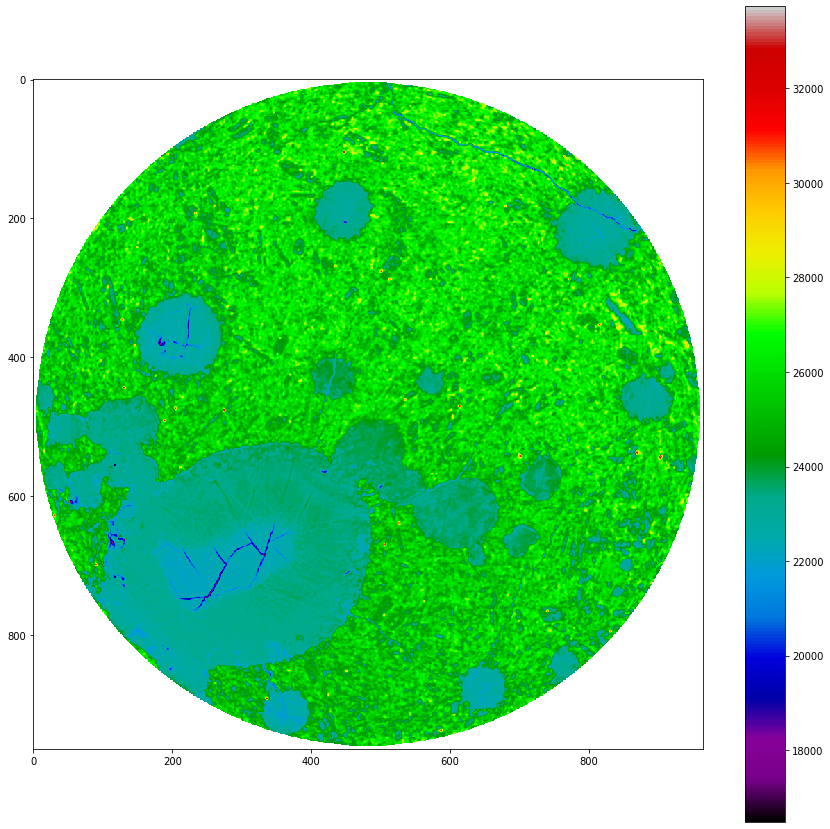

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr_blur, cmap='nipy_spectral')
fig.colorbar(cbar)

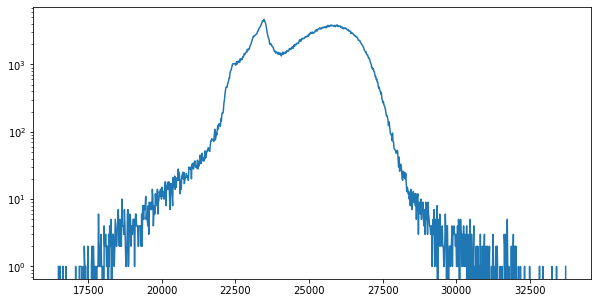

In [20]:
h, e = np.histogram(imarr_blur[~np.isnan(imarr_blur)].flatten(), bins=1000)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(e[:-1], h)
ax.set_yscale('log')

In [21]:
peaks, other = find_peaks(h, height=1e3, width=4)

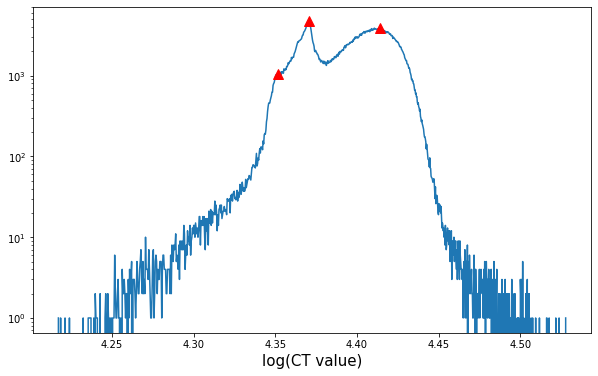

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.log10(e[:-1])

ax.plot(x, h)
ax.set_yscale('log')
ax.set_xlabel('log(CT value)', fontsize=15)
# ax.set_ylim(1e1, 1e8)

ax.plot(x[peaks], h[peaks], marker='^', markersize=10, linewidth=0, color='red')

In [23]:
other

{'peak_heights': array([1034., 4684., 3881.]),
 'prominences': array([  58., 4684., 2544.]),
 'left_bases': array([105, 105, 439]),
 'right_bases': array([349, 747, 747]),
 'widths': array([ 5.64867725, 32.90918473, 94.57707055]),
 'width_heights': array([1005., 2342., 2609.]),
 'left_ips': array([342.81428571, 381.89473684, 491.11042945]),
 'right_ips': array([348.46296296, 414.80392157, 585.6875    ])}

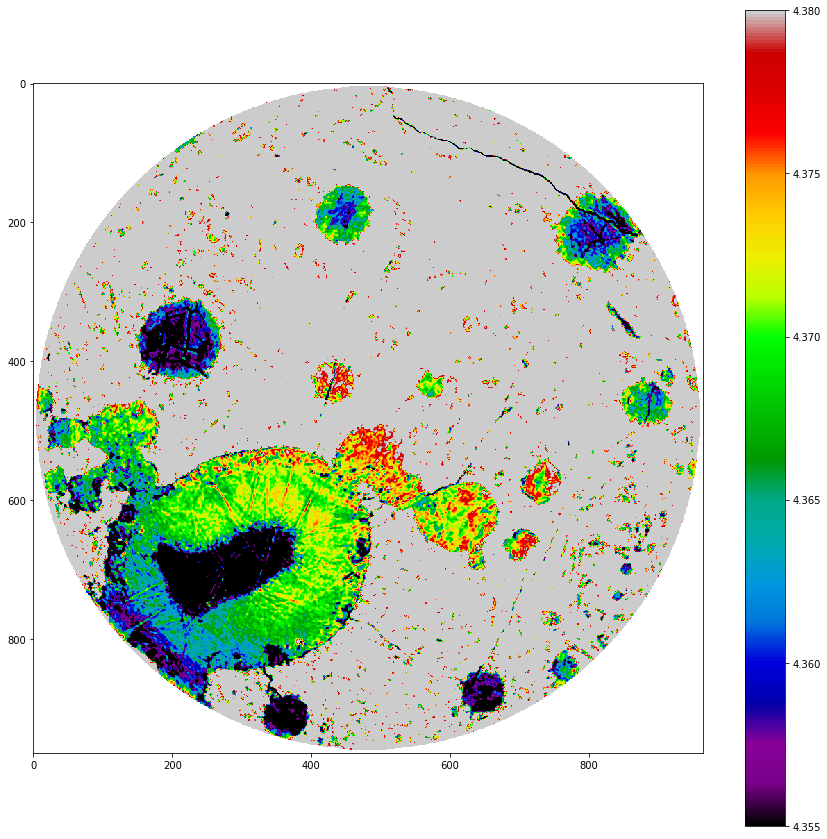

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

cbar = ax.imshow(np.log10(imarr_blur), cmap='nipy_spectral', vmin=4.355, vmax=4.38)

fig.colorbar(cbar)

In [38]:
h = hessian(imarr_blur, sigmas=[2, 2])

In [39]:
l = label(h)

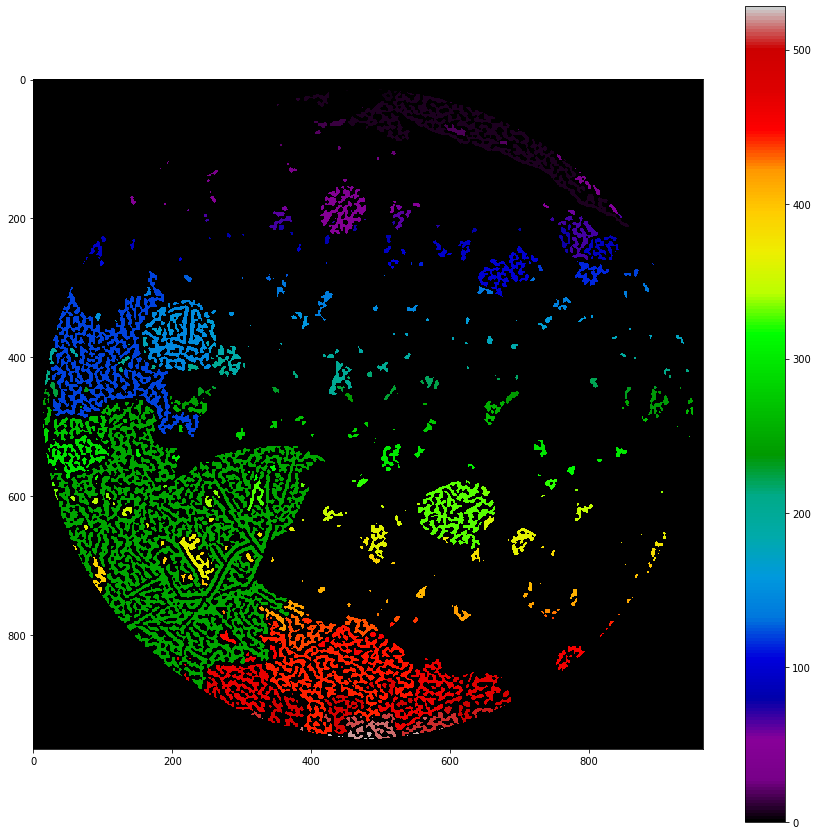

In [40]:
fig, ax = plt.subplots(figsize=(15, 15))

cbar = ax.imshow(l, cmap='nipy_spectral')

fig.colorbar(cbar)

In [41]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


In [42]:
distance = ndi.distance_transform_edt(imarr_blur)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=imarr_blur)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
# labels = watershed(-distance, markers, mask=image)

/home/john/anaconda3/lib/python3.7/site-packages/skimage/feature/peak.py:132: RuntimeWarning: invalid value encountered in greater_equal
  mask = labels >= 1


NameError: name 'image' is not defined

In [43]:
labels = watershed(-distance, markers, mask=imarr_blur)

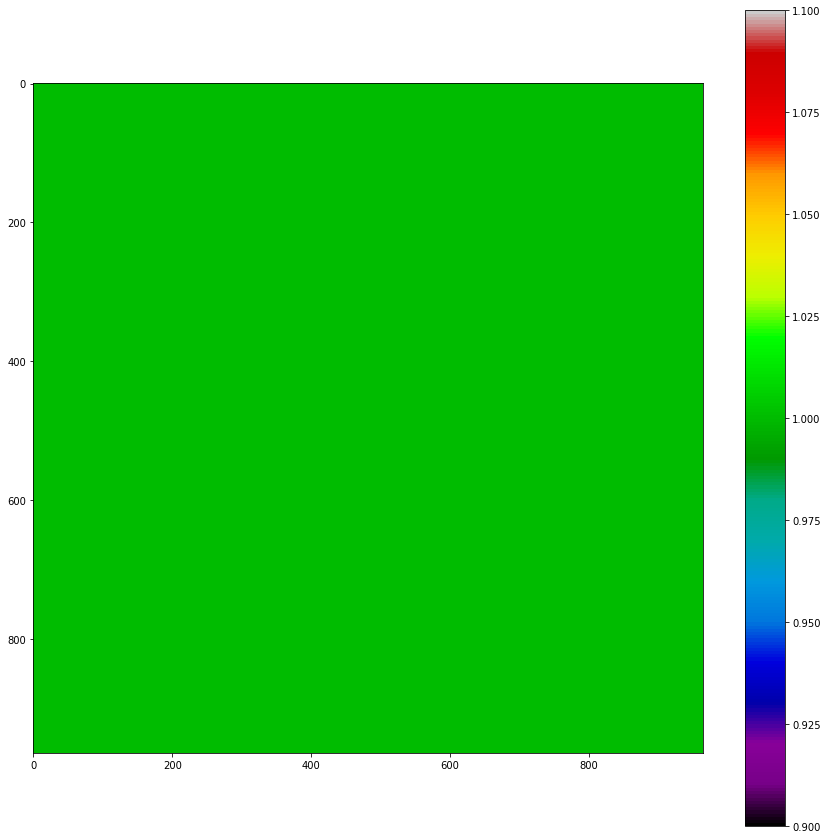

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))

cbar = ax.imshow(labels, cmap='nipy_spectral')

fig.colorbar(cbar)